# CA-2.2 Image Segmentation
## Part II: Color Segmentation
***
* ID: A0248839J
* Name: Dahyun Kim
1. First, implement K-mean clustering to initialize the segmentation, and to obtain K-center colors. The user should be able to enter the value of K (the number of the segmented colors). Then, build MRFs with multilabels and optimize by using the multilabel graphcuts (using PyMaxFlow). In the multilabel graphcuts, you should define the smoothness cost when two labels are the same (e.g. cost = 0) and when they are different (e.g. cost = 1). The data cost can be defined as the distance between the pixel color to each of the K-center colors.
2. Show the segmentation results of a given images with different settings of K.
Discuss the drawbacks of the algorithm. How can you improve the algorithm?
3. Show the best segmentation results of at least 3 different input images.


### 1. Import libraries

In [1]:
# Import Libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import maxflow
import random
import cv2

### 2. Function `dist`
* The function `dist` calculates the distance between two images.

In [2]:
# Calculates the Euclidean distance between images.
def dist(img1, img2):
    
    dist_R = abs(img1[:,:,0] - img2[:,:,0])
    dist_G = abs(img1[:,:,1] - img2[:,:,1])
    dist_B = abs(img1[:,:,2] - img2[:,:,2])
    dist = (dist_R + dist_G + dist_B)/3
    dist = dist.astype('uint8')
    
    return dist

### 3. Function `make_img`
* The function `make_img` makes an image of `shape` with color `color`.

In [3]:
def make_img(color, shape):
    img = np.zeros((shape))
    for x in range(0, shape[0]):
        for y in range(0, shape[1]):
            img[x,y] = color
    return img

### 4. Open image
* Let's open an image for segmentation.

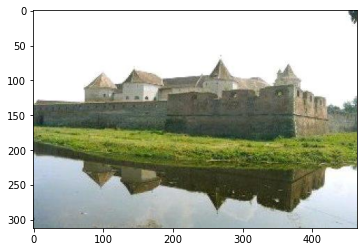

In [4]:
# Open image.
path = 'pic2.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x_shape, y_shape, dim = img.shape
plt.imshow(img)

### 5. Implement K-mean clustering
* Part II (1).
* Implement K-mean clustering to initialize the segmentation, and to obtain K-center colors. The *OpenCV* `cv.kmeans()` function is used for the K-mean clustering.
* The user can enter the value of K. (K=5 is recommended for this image.)
* The result is shown below.

Enter the value of K (the number of the segmented colors): 5


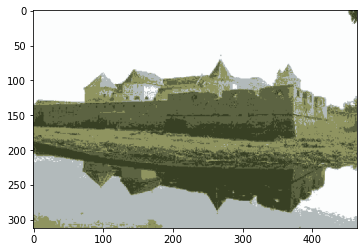

In [5]:
# Samples should be of np.float32 data type,
# and each feature should be put in a single column.
flat_img = img.reshape((-1,3))
flat_img = np.float32(flat_img)

# Define stopping criteria.
# Max iterations: 100, epsilon = 1.0
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)

# Get the number of the clusters
k = int(input('Enter the value of K (the number of the segmented colors): '))

# Apply kmeans.
# labels: cluster label for each pixel. (0, 1, ... ,k-1)
# centers: center points. (each center's RGB values)
# cv2.KMEANS_RANDOM_CENTERS: randomly assign the values of the clusters initially.
ret, labels, centers = cv2.kmeans(flat_img, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to int
centers = np.uint8(centers)
# flatten labels
labels = labels.flatten()

# Get the segmented image.
seg_img = centers[labels] # flattened segmentation image.
seg_img = seg_img.reshape(img.shape)

plt.imshow(seg_img)

### 6. Build MRF and use multilabel graphcuts.
* Part II (1)
* Build MRFs with multilabels and optimize by using the multilabel graphcuts.
* We can use the *Alpha-expansion* algorithm for multi-label MRF. The function `alpha_expansion` performs the algorithm, and returns the optimal result, `result_img`.

In [6]:
def alpha_expansion(alpha, centers, m_lambda, shape, segmented_img):
    # Set colors
    # Start with label 0 and 1.
    Source_color = centers[alpha]
    Sink_color = centers[1]
    Source_img = make_img(Source_color, shape) #'0'
    Sink_img = make_img(Sink_color, shape) #'1'
    
    # Make MRF
    g = maxflow.Graph[int]()
    nodeids = g.add_grid_nodes((shape[0], shape[1]))
    g.add_grid_edges(nodeids, m_lambda)
    g.add_grid_tedges(nodeids, dist(Source_img, segmented_img), dist(Sink_img, segmented_img))
    
    # Graphcut
    g.maxflow()
    sgm = g.get_grid_segments(nodeids)
    new_img_array = np.int_(np.logical_not(sgm))
    
    # Make initial result image.
    result_img = centers[new_img_array]
    
    # Repeat for all labels and reconstruct image.
    for i in range(2,len(centers)):
        Sink_color = centers[i]
        Source_img = make_img(Source_color, shape) #'0'
        Sink_img = make_img(Sink_color, shape) #'1'
        g = maxflow.Graph[int]()
        nodeids = g.add_grid_nodes((shape[0], shape[1]))
        g.add_grid_edges(nodeids, m_lambda)
        g.add_grid_tedges(nodeids, dist(Source_img, segmented_img), dist(Sink_img, segmented_img))

        g.maxflow()
        sgm = g.get_grid_segments(nodeids)
        new_img_array = np.int_(np.logical_not(sgm))

        for x in range(0,shape[0]):
            for y in range(0,shape[1]):
                if new_img_array[x,y] == 1:
                    result_img[x,y] = Sink_color
                    
    return result_img

### 7.  Segmentation results
* Apply `alpha_expansion`.
* The result of segmentation is shown below.

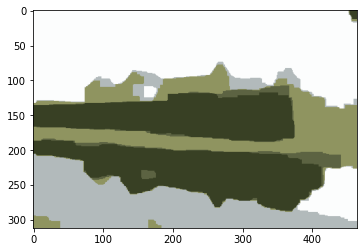

In [7]:
#REalpha_expansion(alpha, centers, m_lambda, shape, segmented_img):
result_img = alpha_expansion(0, centers, 200, img.shape, seg_img)
plt.imshow(result_img.astype('uint8'))

### 8. Different settings of K
* Part II (2).
* Let's see the segmentation result of different settings of K. Like before, user can enter the new value of K.
* First, perform k-clustering again for initialization, then alpha expansion. The result if shown below.
* ( The best value of K is 5 for this image.)

Enter the value of K (the number of the segmented colors): 3


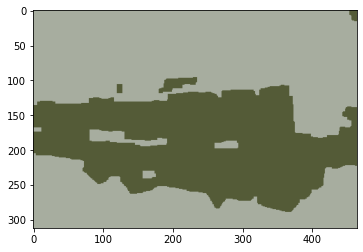

In [8]:
img1 = cv2.imread(path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
x_shape1, y_shape1, dim1 = img1.shape

flat_img1 = img1.reshape((-1,3))
flat_img1 = np.float32(flat_img1)

k = int(input('Enter the value of K (the number of the segmented colors): '))

ret1, labels1, centers1 = cv2.kmeans(flat_img1, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers1 = np.uint8(centers1)
labels1 = labels1.flatten()
seg_img1 = centers1[labels1]
seg_img1 = seg_img1.reshape(img1.shape)

#REalpha_expansion(alpha, centers, m_lambda, shape, segmented_img):
result_img1 = alpha_expansion(0, centers1, 200, img1.shape, seg_img1)
plt.imshow(result_img1.astype('uint8'))

### 9. The best segmentation results
* Here are some other segmentation results of different input image.
#### Example 1: Cat
* (recommended K = 6)

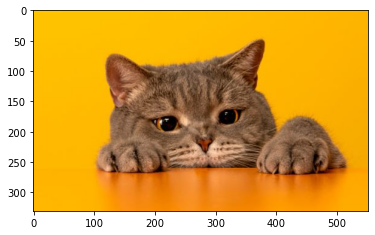

In [9]:
# Open image.
path2 = 'cat.jpg'
img2 = cv2.imread(path2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
x_shape2, y_shape2, dim2 = img2.shape
plt.imshow(img2)

Enter the value of K (the number of the segmented colors): 6


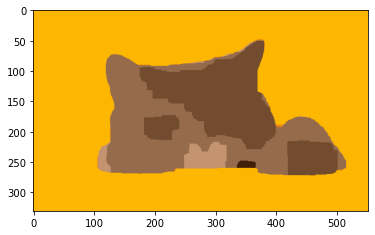

In [21]:
flat_img2 = img2.reshape((-1,3))
flat_img2 = np.float32(flat_img2)

k = int(input('Enter the value of K (the number of the segmented colors): '))

ret2, labels2, centers2 = cv2.kmeans(flat_img2, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers2 = np.uint8(centers2)
labels2 = labels2.flatten()
seg_img2 = centers2[labels2]
seg_img2 = seg_img2.reshape(img2.shape)

#REalpha_expansion(alpha, centers, m_lambda, shape, segmented_img):
result_img2 = alpha_expansion(0, centers2, 200, img2.shape, seg_img2)
plt.imshow(result_img2.astype('uint8'))

#### Example 2: Sign
* (recommended K = 5)

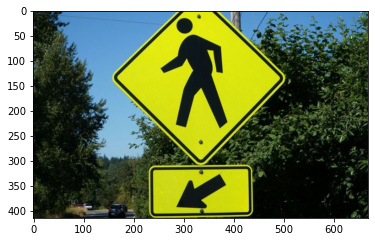

In [11]:
# Open image.
path3 = 'sign.jpg'
img3 = cv2.imread(path3)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
x_shape3, y_shape3, dim3 = img3.shape
plt.imshow(img3)

Enter the value of K (the number of the segmented colors): 5


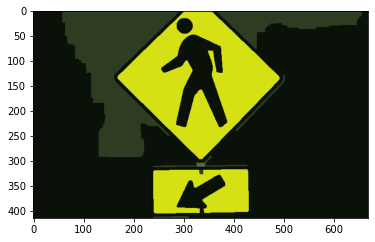

In [12]:
flat_img3 = img3.reshape((-1,3))
flat_img3 = np.float32(flat_img3)

k = int(input('Enter the value of K (the number of the segmented colors): '))

ret3, labels3, centers3 = cv2.kmeans(flat_img3, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers3 = np.uint8(centers3)
labels3 = labels3.flatten()
seg_img3 = centers3[labels3]
seg_img3 = seg_img3.reshape(img3.shape)

#REalpha_expansion(alpha, centers, m_lambda, shape, segmented_img):
result_img3 = alpha_expansion(0, centers3, 200, img3.shape, seg_img3)
plt.imshow(result_img3.astype('uint8'))

#### Example 3: Road
* (recommenced K=6)

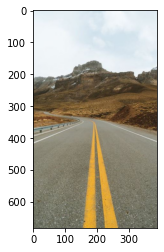

In [13]:
# Open image.
path4 = 'road.jpg'
img4 = cv2.imread(path4)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
x_shape4, y_shape4, dim4 = img4.shape
plt.imshow(img4)

Enter the value of K (the number of the segmented colors): 6


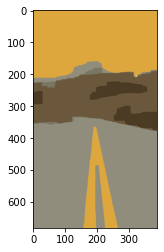

In [16]:
flat_img4 = img4.reshape((-1,3))
flat_img4 = np.float32(flat_img4)

k = int(input('Enter the value of K (the number of the segmented colors): '))

ret4, labels4, centers4 = cv2.kmeans(flat_img4, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers4 = np.uint8(centers4)
labels4 = labels4.flatten()
seg_img4 = centers4[labels4]
seg_img4 = seg_img4.reshape(img4.shape)

#REalpha_expansion(alpha, centers, m_lambda, shape, segmented_img):
result_img4 = alpha_expansion(0, centers4, 200, img4.shape, seg_img4)
plt.imshow(result_img4.astype('uint8'))

### 10. Discuss
* Discuss the drawbacks of the algorithm. How can you improve the algorithm?
    * The drawbacks of this algorithm is mostly the drawbacks of k-mean clustering, like covered during class. The first drawback is that it is hard to set K. We do not know how many clusters are in a image. Thus, we had to set it manually in this code. We need a method to set the value of K automatically.    
    
    * Second drawback is the difficulty of initialization. A lot of calculation is needed for the initialization.     
    
    * The last drawback of the k-mean clustering is that it ignores the spatial information. However, in this algorithm, it was improved by building MRF and optimizing by using the nultilabel graphcuts.